# World models applied to SNEK
Here we want to apply the WorldModels approach to a custom openAI gym environment, called sneks (which resembles the classic snake game). We proceed by incremental steps and we test them stand-alone.

In [1]:
import numpy as np
import tensorflow as tf
import sneks, gym
import matplotlib.pyplot as plt
from tqdm import tnrange

/Users/nicom/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## VAE encoding
First, we want a VAE which correctly encodes the environment state. For this test, we create a VAE and train it on 1000 random states (16x16 images) taken from the environment.

### Collect the data

In [2]:
env = gym.make('snek-rgb-zoom5-v1')
#env = gym.wrappers.Monitor(env, 'tmp_video')

dataset = []

obs = env.reset()
for i in tnrange(1000):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
    dataset.append(obs / 255)
np.random.shuffle(dataset)
print("Generated", len(dataset),"samples.")

[2018-05-13 22:21:22,811] Making new env: snek-rgb-zoom5-v1


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Generated 1000 samples.


### Creating the network structure

In [9]:
BATCH_SIZE = 32
LATENT_SIZE = 64
LEARNING_RATE = 0.0005

tf.reset_default_graph()

# Input image
X = tf.placeholder(dtype=tf.float32, shape=(None, 80, 80, 3))
# Dropout keep proba
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')
learning_rate = tf.placeholder(dtype=tf.float32, shape=(), name='learning_rate')
batch_size = tf.placeholder(dtype=tf.int32, shape=(), name='batch_size')

# ENCODER GRAPH
with tf.variable_scope("encoder", reuse=None):
    conv1 = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    drop1 = tf.nn.dropout(conv1, keep_prob)
    conv2 = tf.layers.conv2d(drop1, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    drop2 = tf.nn.dropout(conv2, keep_prob)
    conv3 = tf.layers.conv2d(drop2, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    drop3 = tf.nn.dropout(conv3, keep_prob)
    flat = tf.layers.flatten(drop3)
    latent_means = tf.layers.dense(flat, units=LATENT_SIZE)
    latent_std = tf.layers.dense(flat, units=LATENT_SIZE)
    latent_noise = tf.random_normal(shape=(batch_size, LATENT_SIZE))
    latent_vector = latent_means + tf.multiply(latent_std, latent_noise)

# DECODER GRAPH
with tf.variable_scope("decoder", reuse=None):
    deflat = tf.layers.dense(latent_vector, units=flat.shape[1])
    deflat4d = tf.reshape(deflat, shape=(-1, drop2.shape[1], drop2.shape[2], drop2.shape[3]))
    deconv1 = tf.layers.conv2d_transpose(deflat4d, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
    dedrop1 = tf.nn.dropout(deconv1, keep_prob)
    deconv2 = tf.layers.conv2d_transpose(dedrop1, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    dedrop2 = tf.nn.dropout(deconv2, keep_prob)
    deconv3 = tf.layers.conv2d_transpose(dedrop2, filters=3, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    dedrop3 = tf.nn.dropout(deconv3, keep_prob)
    rebuild = tf.reshape(dedrop3, shape=(-1, 80, 80, 3))
    
# Loss
reconstruction_loss = tf.reduce_sum(tf.squared_difference(rebuild, X))
reg_loss = tf.reduce_sum(-tf.log(tf.abs(latent_std)) + 0.5 * (tf.square(latent_std) + tf.square(latent_means) - 1))
complete_loss = reconstruction_loss + reg_loss

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(complete_loss)

# Session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
# Training
N_EPOCHS = 300
for epoch in tnrange(200, 300):
    if epoch < 200:
        lr = 0.00001
    else:
        lr *= 0.99
    losses = []
    rlosses = []
    for bindex in range(0, len(dataset), BATCH_SIZE):
        batch = dataset[bindex:bindex+BATCH_SIZE]
        _loss, _rloss, _ = sess.run([complete_loss, reconstruction_loss, optimizer], feed_dict = {X: batch, keep_prob:0.9, learning_rate:lr, batch_size:len(batch)})
        losses.append(_loss)
        rlosses.append(_rloss)
    if epoch % 10 == 0:
        print("Epoch", epoch, "- Mean Loss:", np.mean(losses), "Reconstruction:", np.mean(rlosses), "LR:", lr)

HBox(children=(IntProgress(value=0), HTML(value='')))

Epoch 200 - Mean Loss: 3126.376 Reconstruction: 1050.3125 LR: 9.9e-06
Epoch 210 - Mean Loss: 2963.4055 Reconstruction: 1053.3357 LR: 8.953382542587162e-06
Epoch 220 - Mean Loss: 2819.246 Reconstruction: 1044.4657 LR: 8.097278682212583e-06
Epoch 230 - Mean Loss: 2717.52 Reconstruction: 1061.5295 LR: 7.323033696543972e-06
Epoch 240 - Mean Loss: 2606.9702 Reconstruction: 1061.737 LR: 6.622820409839832e-06
Epoch 250 - Mean Loss: 2503.462 Reconstruction: 1058.979 LR: 5.989560064661607e-06
Epoch 260 - Mean Loss: 2415.329 Reconstruction: 1062.2035 LR: 5.416850759668533e-06
Epoch 270 - Mean Loss: 2353.7334 Reconstruction: 1075.0126 LR: 4.898902730042048e-06
Epoch 280 - Mean Loss: 2294.128 Reconstruction: 1086.5199 LR: 4.4304798162617245e-06
Epoch 290 - Mean Loss: 2220.699 Reconstruction: 1084.3625 LR: 4.006846529515404e-06



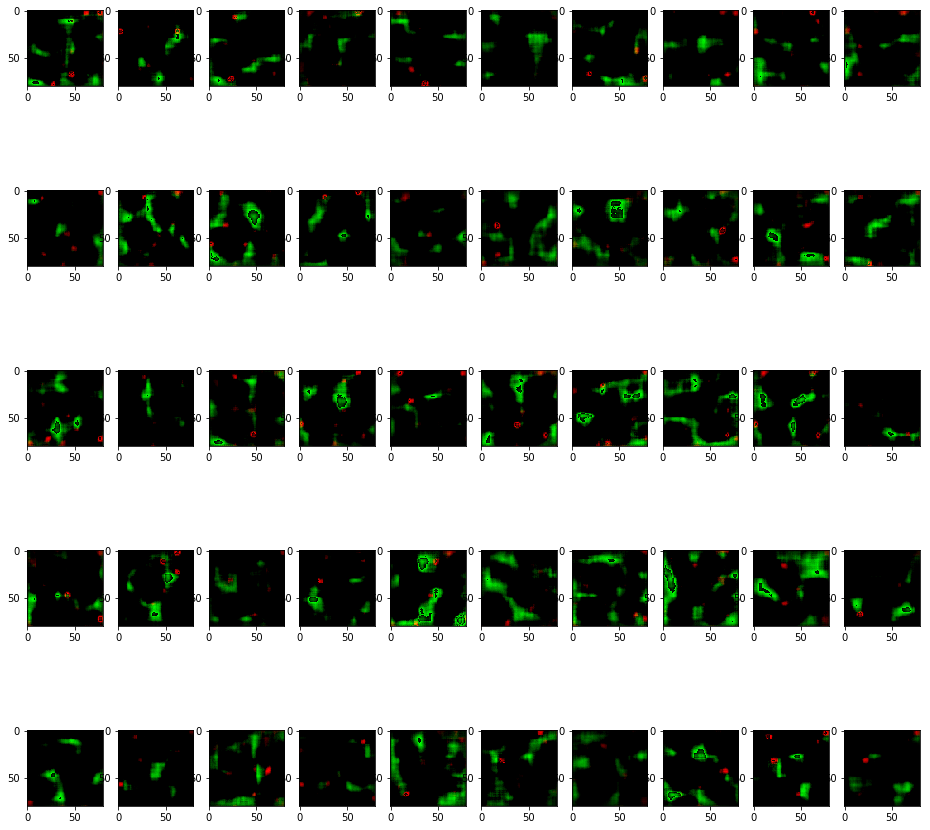

In [17]:
R, C = 5, 10
z = np.random.standard_normal((R*C, LATENT_SIZE))
reco = sess.run(rebuild, feed_dict = {latent_vector: z, keep_prob:1.0})
f, ax = plt.subplots(R, C, figsize=(16,16))
for r in range(R):
    for c in range(C):
        ax[r,c].imshow(reco[r*C + c])
plt.show()

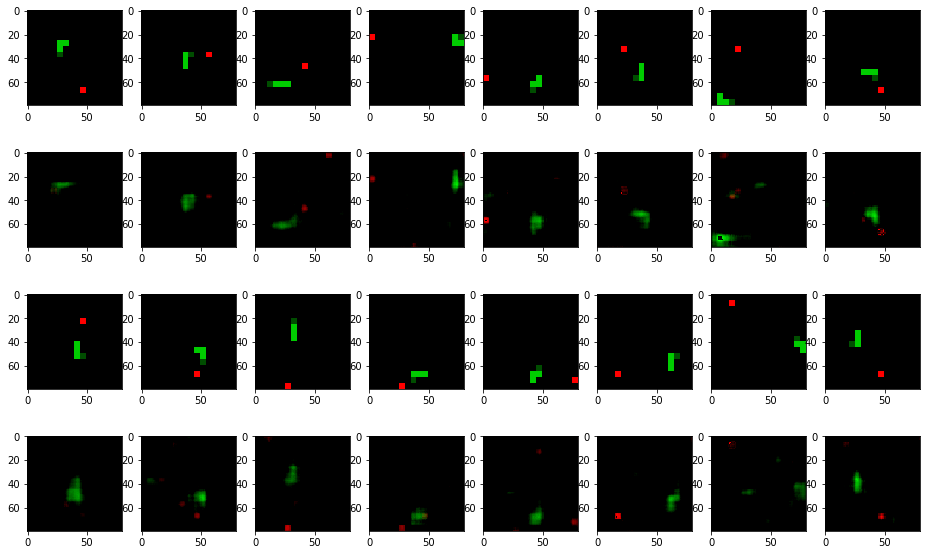

In [18]:
R, C = 2, 8
z = np.random.standard_normal((R*C, LATENT_SIZE))
reco = sess.run(rebuild, feed_dict = {X: dataset[:16], keep_prob:1.0, batch_size:16})
f, ax = plt.subplots(2*R, C, figsize=(16,10))
for r in range(2*R):
    for c in range(C):
        if r % 2 == 0:
            ax[r,c].imshow(dataset[(r//2)*C + c]) 
        else:
            ax[r,c].imshow(reco[(r//2)*C + c])
plt.show()

History:
50 epochs, 0.0001